In [1]:
from Bio import SeqIO
import re
from os import listdir
from os.path import isfile, join
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm as tqdm # progress bar
%matplotlib inline

### 1. Read data

In [2]:
ROOT_DIR = '.'

def get_data(fname):
    file2positions = {}
    all_pos = 0

    with open(join(ROOT_DIR, "editing_sites_" + fname + "_plus.txt")) as f:
        f.readline()
        for line in f:
            s = line.strip().split()
            name, pos, degree = s[0], int(s[3]), float(s[7]) 

            if not name in file2positions:
                file2positions[name] = {}
            file2positions[name][pos] = degree
            all_pos += 1
    print(all_pos)
    
    name2as = {}
    name2len = {}
    name2unred = {}
    seqs = SeqIO.parse(join(ROOT_DIR, "orfs_" + fname + "_plus.fa"), "fasta")
    for seq in seqs:
        name = str(seq.id)
        s = str(seq.seq)
        co = [m.start()+1 for m in re.finditer('A', s)]
        name2as[name] = co
        name2len[name] = len(s)
        name2unred[name] = []
        for pos in co:
            if not name in file2positions:
                name2unred[name] += co
                break
            if not pos in file2positions[name]:
                name2unred[name].append(pos)
                
    mypath = fname
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

    name2cov = {}
    k = 1
    for fi in tqdm(onlyfiles):
        with open(join(mypath, fi)) as f:
            name = fi.split(".")[0]
            cov = [0] * name2len[name]
            for line in f:
                s = line.strip().split()
                begin, end, score = int(s[1]), int(s[2]), float(s[4])
                for i in range(begin, end):
                    cov[i] = min(cov[i], score)
            name2cov[name] = cov
        k += 1          
        
    return file2positions, name2as, name2len, name2cov, name2unred

### 2. Count fraction of A-red covered by RNA secondary structure

In [5]:
def get_red_stat(file2positions, name2len, name2cov, t, e=100):
    red_struc = 0
    red_unstruc = 0

    for name in name2len:
        cov = name2cov[name]
        if name in file2positions:
            pos2deg = file2positions[name]
            for pos in pos2deg:
                if pos2deg[pos] < t or pos2deg[pos] > e: continue
                pos = pos - 1
                if cov[pos] == 0:
                    red_unstruc += 1
                else:
                    red_struc += 1
        
    a = red_struc/(red_unstruc + red_struc)  
    return a

def get_unred_stat(name2len, name2cov, name2unred):
    unred_struc = 0
    unred_unstruc = 0
    for name in name2len:
        cov = name2cov[name]
        unred = name2unred[name]
        for pos in unred:
            pos = pos - 1
            if cov[pos] == 0:
                unred_unstruc += 1
            else:
                unred_struc += 1
    b = unred_struc/(unred_unstruc + unred_struc)
    return b

oct
117842


100%|██████████| 13005/13005 [00:54<00:00, 252.05it/s]


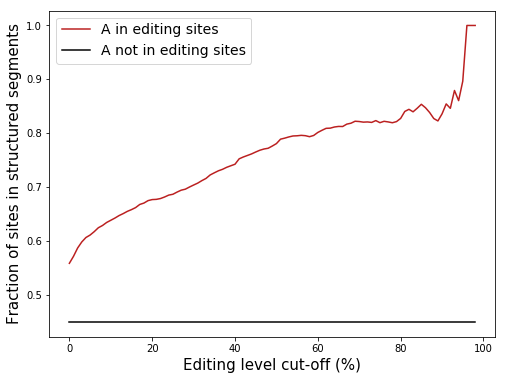

bim
76862


FileNotFoundError: [Errno 2] No such file or directory: 'bim'

In [4]:
colours = ["#BB2020", "#BB2020", "#0000BB", "#0000BB", "#505046", "#505046"]

for i, name in enumerate(["oct", "bim", "squ", "sep", "apl", "nau"]):
    
    print(name)
    file2positions, name2as, name2len, name2cov, name2unred = get_data(name)

    x = list(range(99))
    y = []
    z = []
    z_item = get_unred_stat(name2len, name2cov, name2unred)
    for t in range(99):
        y_item = get_red_stat(file2positions, name2len, name2cov, t)
        y.append(y_item)
        z.append(z_item)
        
    width, height = 8, 6
    mpl.rcParams['figure.figsize'] = [width, height]

    plt.plot(x,y, color=colours[i])
    plt.plot(x,z, color="black")
    plt.xlabel("Editing level cut-off (%)", size=15)
    plt.ylabel("Fraction of sites in structured segments", size=15)
    plt.legend(["A in editing sites", "A not in editing sites"], fontsize=14)

    plt.savefig("Fig1_" + name + ".pdf", format="pdf")
    plt.show()
    plt.close()

### 3. Sort editing sites by their influence on protein sequence

In [16]:
file2positions = {}
all_pos = 0
with open("editing_sites_squ_plus.txt") as f:
    f.readline()
    for line in f:
        s = line.strip().split()
        name, pos, degree = s[0], int(s[3]), float(s[7]) 

        if not name in file2positions:
            file2positions[name] = {}
        file2positions[name][pos] = degree
        all_pos += 1
print(all_pos)

data = pd.read_csv(join(ROOT_DIR, "editing_sites_squ_plus.txt"), sep="\t")
codon_changes_groups = data.groupby(data['Codon changes'])

syn_edits = {}
non_syn_edits = {}

for group in codon_changes_groups:
    if group[0] == "syn":
        syn_edits.update(group[1].T.to_dict())
    else:
        non_syn_edits.update(group[1].T.to_dict())
      
print(len(syn_edits), len(non_syn_edits))    

82975
28688 54287


In [17]:
file2positions_syn = {fname:{syn_edits[h]["Editing location inside sequence"]:syn_edits[h]["Editing levels [%] "] for h in syn_edits if syn_edits[h]["#Trinity name"] == fname} for fname in file2positions}
file2positions_nonsyn = {fname:{non_syn_edits[h]["Editing location inside sequence"]:non_syn_edits[h]["Editing levels [%] "] for h in non_syn_edits if non_syn_edits[h]["#Trinity name"] == fname} for fname in file2positions}

### 5. Plot histograms of structured fractions

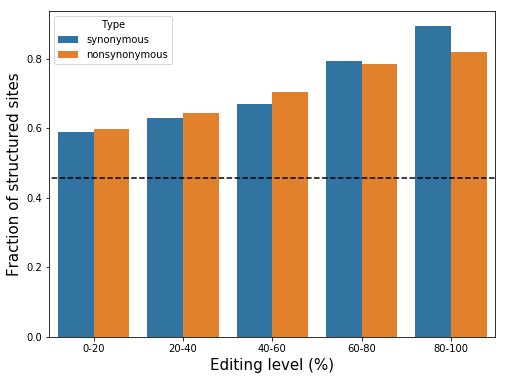

In [19]:
syn_percentage = []
syn_type = []
syn_str_fraction = []

for i in range (20, 101, 20):
    fraction = get_red_stat(file2positions_syn, i-20, i)
    syn_str_fraction.append(fraction)
    syn_percentage.append(str(i-20) + "-" + str(i))
    syn_type.append("synonymous")
    
non_syn_percentage = []
non_syn_type = []
non_syn_str_fraction = []

for i in range (20, 101, 20):
    fraction = get_red_stat(file2positions_nonsyn, i-20, i)
    non_syn_str_fraction.append(fraction)
    non_syn_percentage.append(str(i-20) + "-" + str(i))
    non_syn_type.append("nonsynonymous")   
    
d = {"Editing level (%)": syn_percentage + non_syn_percentage, "Type": syn_type + non_syn_type, "Fraction of structured sites": syn_str_fraction + non_syn_str_fraction}
df = pd.DataFrame(data=d)

bar = sns.barplot(x="Editing level (%)", y="Fraction of structured sites", hue="Type", data=df)
plt.plot(list(range(-1, 6)), [get_unred_stat()]*7, '--k')

plt.xlabel("Editing level (%)", size=15)
plt.ylabel("Fraction of structured sites", size=15)

plt.show()